Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Read data

In [2]:
data = pd.read_csv('data/Churn_Modelling.csv')

Get `shape`

In [3]:
data.shape

(10000, 14)

Print first five rows

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Get *baseline* accuracy

In [5]:
max(data['Exited'].mean(), 1-data['Exited'].mean())

0.7963

Specify target and feature columns

In [6]:
target = 'Exited'
features = [
    'CreditScore', 
    'Geography',
    'Gender', 
    'Age', 
    'Tenure', 
    'Balance', 
    'NumOfProducts', 
    'HasCrCard',
    'IsActiveMember', 
    'EstimatedSalary',
]

#### Statsmodels - Logistic regression

In [7]:
import statsmodels.formula.api as smf

Create training data

In [8]:
train = data.sample(frac=0.75, random_state=42)

Create testing data

In [9]:
test_idx_values = [val for val in data.index if val not in train.index]
test = data.loc[test_idx_values, :]

Get training data shape

In [10]:
train.shape

(7500, 14)

Get testing data shape

In [11]:
test.shape

(2500, 14)

Demonstrate how to use join to get string of features with *plus* signs

In [12]:
features_sum = ' + '.join(features)
features_sum

'CreditScore + Geography + Gender + Age + Tenure + Balance + NumOfProducts + HasCrCard + IsActiveMember + EstimatedSalary'

Get regression formula

In [13]:
formula = f'{target} ~ {features_sum}'
formula

'Exited ~ CreditScore + Geography + Gender + Age + Tenure + Balance + NumOfProducts + HasCrCard + IsActiveMember + EstimatedSalary'

Fit logistic regression

In [14]:
reg = smf.logit(formula, train).fit()

Optimization terminated successfully.
         Current function value: 0.425038
         Iterations 6


Print regression summary

In [15]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Exited   No. Observations:                 7500
Model:                          Logit   Df Residuals:                     7488
Method:                           MLE   Df Model:                           11
Date:                Thu, 16 Nov 2023   Pseudo R-squ.:                  0.1547
Time:                        10:19:34   Log-Likelihood:                -3187.8
converged:                       True   LL-Null:                       -3771.0
Covariance Type:            nonrobust   LLR p-value:                2.860e-243
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.5989      0.284    -12.676      0.000      -4.155      -3.042
Geography[T.Germany]     0.7719      0.078      9.849      0.000       0.618       0.925
Geography[T.Spain]       0.0236      0.082      0.287      0.774      -0.138       0.185
Gender[T.Male]          -0.5354      0.063     -8.463      0.000      -0.659      -0.411
CreditScore             -0.0005      0.000     -1.517      0.129      -0.001       0.000
Age                      0.0753      0.003     25.012      0.000       0.069       0.081
Tenure                  -0.0068      0.011     -0.630      0.528      -0.028       0.014
Balance               2.523e-06   5.97e-07      4.228      0.000    1.35e-06    3.69e-06
NumOfProducts           -0.1050      0.054     -1.928      0.054      -0.212       0.002
HasCrCard               -0.0915      0.068     -1.339      0.181      -0.225       0.042
IsActiveMember          -1.0882      0.067    -16.187      0.000      -1.220      -0.956
EstimatedSalary       2.955e-07   5.49e-07      0.538      0.591   -7.81e-07    1.37e-06
========================================================================================
"""

Get positive probabilities using regression model

In [16]:
positive_probabilities = reg.predict(test)
test['positive_probabilities'] = positive_probabilities

Print first five rows

In [17]:
test.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,positive_probabilities
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.148853
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.152503
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,0.242129
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0,0.033053
11,12,15737173,Andrews,497,Spain,Male,24,3,0.00,2,1,0,76390.01,0,0.054779


Run simple experiment to observe how accuracy changes as threshold varies

In [18]:
experiment_data = []

for threshold in [0.1, 0.2, 0.3, 0.4, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.6, 0.7, 0.8, 0.9]:

    test['prediction'] = (test['positive_probabilities'] >= threshold).astype(int)
    accuracy = (test['Exited'] == test['prediction']).astype(int).mean()
    experiment_data.append([threshold, accuracy])

experiment_data

[[0.1, 0.5112],
 [0.2, 0.7016],
 [0.3, 0.7764],
 [0.4, 0.7968],
 [0.46, 0.8088],
 [0.47, 0.8104],
 [0.48, 0.8136],
 [0.49, 0.8156],
 [0.5, 0.8152],
 [0.51, 0.8128],
 [0.52, 0.8124],
 [0.53, 0.8124],
 [0.54, 0.8116],
 [0.55, 0.8112],
 [0.6, 0.804],
 [0.7, 0.7952],
 [0.8, 0.7912],
 [0.9, 0.7908]]

#### Scikit-learn - Random forest

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

Make copy of data for work in scikit-learn

In [20]:
skdata = data.copy()
skdata.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Get dummies for string columns (one hot encoding)

In [28]:
skdata = data.copy()

string_columns = ['Geography', 'Gender']

for string_column in string_columns:
    print(f'{string_column}')
    
    dummies = pd.get_dummies(
        skdata[string_column], 
        drop_first=True,
        prefix=string_column,
    ).astype(int)
    
    skdata = skdata.drop(columns=[string_column])
    skdata = pd.concat([skdata, dummies], axis=1)

skdata.head()

Geography
Gender


,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Define updated target and feature columns

In [29]:
target = 'Exited'
features = [
    'CreditScore', 
    'Age', 
    'Tenure',
    'Balance', 
    'NumOfProducts', 
    'HasCrCard', 
    'IsActiveMember',
    'EstimatedSalary', 
    'Geography_Germany', 
    'Geography_Spain',
    'Gender_Male',
]

Create training and testing datasets

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    skdata[features], 
    skdata[target], 
    test_size=0.25, 
    random_state=42,
    stratify=skdata[target],
)

In [31]:
print(f'{skdata[target].mean() = }')
print(f'{y_train.mean() = }')
print(f'{y_test.mean() = }')

skdata[target].mean() = 0.2037
y_train.mean() = 0.20373333333333332
y_test.mean() = 0.2036


Fit *default* random forest classifier

In [32]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Get accuracy for random forest classifier.

In [33]:
clf.score(X_test, y_test)

0.8656

<Axes: xlabel='Feature'>

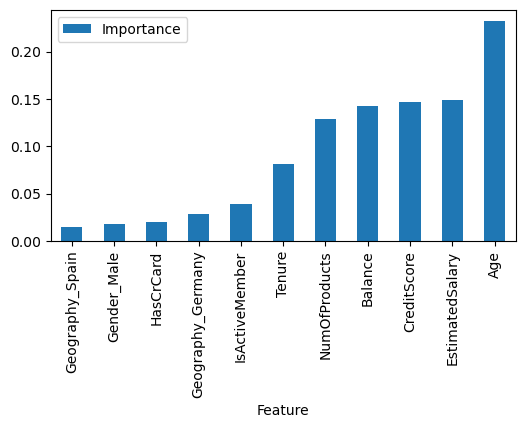

In [34]:
importances_df = []
for feature, importance in zip(features, clf.feature_importances_):
    importances_df.append([feature, importance])
importances_df = pd.DataFrame(
    importances_df,
    columns=['Feature', 'Importance'],
)

importances_df = importances_df.sort_values('Importance')
importances_df.plot(
    kind='bar',
    x='Feature',
    y='Importance',
    figsize=(6, 3),
)

In [44]:
%%time

base_clf = RandomForestClassifier(random_state=42)

parameters = {
    'n_estimators': [100, 200],
    'max_depth': [2, 4, 6],
    'criterion': ["gini", "entropy", "log_loss"],
}

GS = GridSearchCV(base_clf, parameters, n_jobs=-1, scoring='balanced_accuracy')
GS.fit(X_train, y_train)

CPU times: user 787 ms, sys: 44.3 ms, total: 831 ms
Wall time: 13.3 s


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6], 'n_estimators': [100, 200]},
             scoring='balanced_accuracy')

In [45]:
best_clf = GS.best_estimator_
best_clf.score(X_test, y_test)

0.862

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

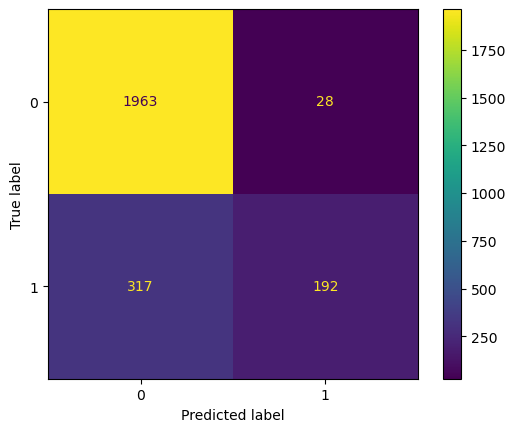

In [47]:
ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test)

In [50]:
best_clf.predict_proba(X_test)[:, 1]

array([0.1084359 , 0.1053054 , 0.11689886, ..., 0.59527931, 0.16439401,
       0.16609018])